# Automatic PKIKP Onset Phase Picker

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tsonpham/ObsSeis-VNU/blob/master/Day5/D5_Lab.ipynb)

This notebook demonstrates an application of convolutional neural network in observational seismology. The AI tool helps to automatize the laborious data collection process previously performed by analysts at large data centers. Here, we develop a CNN tool to pick the onset of PKIKP waves, the compressional waves transversing the whole Earth diameter, including the Earth's inner core. We expect that the ever-expanded dataset havested by the AI tool could help reveal new insights into the structures and dynamics of the Earth's inner core.

This google colab documnent is adopted from the orignal [github](https://github.com/JiarunZhou/PKIKP_Onset_Picker.git) repository developed by PhD Scholar Jiarun Zhou (ANU) supplementing the following application:

* Zhou J., T.-S. Phạm, H. Tkalčić, Deep-learning phase-onset picker for deep Earth seismology: PKIKP waves, Journal of Geophysical Research: Solid Earth, 129 (9), [10.1029/2024JB029360](https://doi.org/10.1029/2024JB029360), 2024.

### STEP 0: Preparing the working environment

Run the next cell to install Python packages in the working environments of the Colab session. Note that, the packages are removed from the evironment when this session is closed.


We will be using a GPU device to train our network. Select `Runtime`, `Change runtime type`, pick your preferred GPU device.

In [1]:
!pip install obspy

## Training the convolutional neural network for PKIKP onset picker

#### Download training datasets

We download the training datasets consisting of synthetic waveforms and labels. The datasets include three subsets: regular (synthetic P waves), target (particular emergent P waves), and control set (real noise). The waveforms are sampled at 40 Hz and generated to 20-s long. Non-zero labels mark the PKIKP wave onset, while zero labels indicate noise waveforms.

The datasets were simulated to mimic main features of teleseismic PKIKP waves transversing the Earth's inner core. The following cell download the compressed datasets in `hdf5` format from their hosted github repository.

In [7]:
# !wget https://github.com/JiarunZhou/PKIKP_Onset_Picker/raw/51d719642f03a49ef5f950866d12a8c2973cca21/Training_data/Noise.hdf5
# !wget https://github.com/JiarunZhou/PKIKP_Onset_Picker/raw/51d719642f03a49ef5f950866d12a8c2973cca21/Training_data/RegularP.hdf5
!wget https://github.com/JiarunZhou/PKIKP_Onset_Picker/raw/51d719642f03a49ef5f950866d12a8c2973cca21/Training_data/TargetP.hdf5

!du -sh *.hdf5

--2025-03-18 02:27:17--  https://github.com/JiarunZhou/PKIKP_Onset_Picker/raw/51d719642f03a49ef5f950866d12a8c2973cca21/Training_data/TargetP.hdf5
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/JiarunZhou/PKIKP_Onset_Picker/51d719642f03a49ef5f950866d12a8c2973cca21/Training_data/TargetP.hdf5 [following]
--2025-03-18 02:27:17--  https://media.githubusercontent.com/media/JiarunZhou/PKIKP_Onset_Picker/51d719642f03a49ef5f950866d12a8c2973cca21/Training_data/TargetP.hdf5
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 315403808 (301M) [application/octet-stream]
Saving to: ‘TargetP.h

The three files downloaded are 301M in size:
```
301M	Noise.hdf5
301M	RegularP.hdf5
301M	TargetP.hdf5
```
Each contains 100,000 waveforms of 20 seconds long sampled at 40 samples per second.

Next, the datasets are loaded into memory as `np.array`.

In [26]:
from pathlib import Path
import h5py
import numpy as np

## basic parameters
sampling_rate = 40
waveform_len = 20
loading_num = 10000

## Load waveforms and onset labels.
waveforms = [] # waveforms
labels = [] # onset labels
names = [] # sub dataset names
for file in Path('.').glob('*.hdf5'):
    with h5py.File(file, "r") as f: # open hdf5 and read content
        data = np.array(f["data"])[:loading_num]
        t0 = np.array(f["t0"])[:loading_num]
    waveforms.append(data)
    labels.append(t0)
    names.append(file.name.split('.')[0])
print ('Datasets:', names)
print ("Total number of samples: %d"%sum([len(_) for _ in waveforms]))

Datasets: ['TargetP', 'RegularP', 'Noise']
Total number of samples: 30000


The total number of samples, i.e., pairs of waveform and onset label, are loaded are 295,275.

The following cell show 30 samples randomly picked from the datasets.

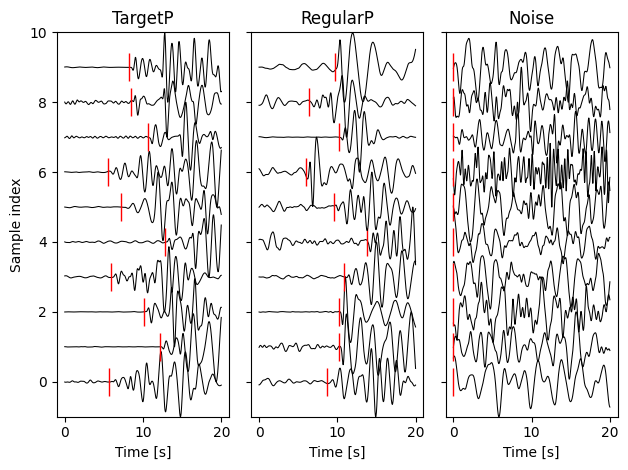

In [37]:
import matplotlib.pyplot as plt
tvec = np.arange(sampling_rate*waveform_len) / sampling_rate
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
for i in range(3):
    tmp = np.random.randint(0, len(waveforms[i]), 10) # pick 10 random waveforms from the i-th subset
    for j in range(len(tmp)):
        # plot waveforms
        ax[i].plot(tvec, waveforms[i][tmp[j]] + j, c='k', lw=0.75)
        # plot labels
        ax[i].plot(labels[i][tmp[j]], j, '|r', ms=20, lw=1.5)
    ax[i].set(xlabel='Time [s]', title=names[i])
ax[0].set(ylabel='Sample index', ylim=(-1, 10))
fig.tight_layout()
plt.show()

### Model Training

Now, we build a neural network, whose architecture is visualized below, using tensorflow keras modules.

<div>
<center>
<img src="https://agupubs.onlinelibrary.wiley.com/cms/asset/952cff41-9b65-4343-8cd8-678090e9f543/jgrb56919-fig-0004-m.jpg" width="300"/>
</div>
(Source: https://doi.org/10.1029/2024JB029360)

In [28]:
## import necessary tensorflow keras modules
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.losses import Huber, Reduction
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def create_CNN_picker(npts, normalize = True, lr = 0.001):
    ## define convolutional neural layers
    n_filters = [32, 64, 128, 256]
    s_kernels = [7, 5, 4, 3]
    inputs = Input(shape=(npts,1))
    x = inputs
    for n_filter, s_kernel in zip(n_filters, s_kernels):
        x = Conv1D(filters = n_filter, kernel_size = s_kernel, padding = 'same', activation = "relu")(x)
        x = MaxPooling1D()(x)
        if normalize:
            x = BatchNormalization()(x)

    ## flatten the output of the convolutional layers
    x = Flatten()(x)

    ## define fully connected, i.e., dense, layers
    for _ in range(2):
        x = Dense(200, activation = 'relu')(x)
        if normalize:
            x = BatchNormalization()(x)

    ## output of the dense layer
    outputs = Dense(1, activation = "linear")(x)

    ## define the CNN model and specify loss function and optimizer
    model = Model(inputs = inputs, outputs = outputs)
    model.compile(loss=Huber(reduction = Reduction.SUM_OVER_BATCH_SIZE),
                  optimizer=Adam(learning_rate = lr))

    return model

## call the definition function to instatitate the CNN model
model_raw = create_CNN_picker(npts = waveform_len*sampling_rate)

## print model sumary
model_raw.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 800, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 800, 32)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 400, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 400, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 400, 64)             │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 200, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 200, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 200, 128)            │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 100, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 100, 256)            │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 50, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 50, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 200)                 │       2,560,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 200)                 │             800 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 200)                 │          40,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 200)                 │             800 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,746,137 (10.48 MB)

 Trainable params: 2,744,377 (10.47 MB)

 Non-trainable params: 1,760 (6.88 KB)

The expected output reads
```
 Total params: 2,746,137 (10.48 MB)
 Trainable params: 2,744,377 (10.47 MB)
 Non-trainable params: 1,760 (6.88 KB)
```
The number of trainable params, 2,744,377, is the number of parameter that is to be estimated to minimize the `Huber` loss function between waveforms and labels. The minimization problem is done using the `Adam` optimizer. The algorithm interatively find a lower loss value when decending along the direction opposite to the loss function's gradient.

Train the model and plot the curves of loss during the training process. An early stopping method that allows training stops early if the validation loss has no longer decreased over 5 epochs is used.

In [31]:
from time import time
from obspy.core import UTCDateTime

def plot_hist_curve(hist, save_plot):
    train_loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]
    plt.figure()
    plt.plot(range(len(train_loss)),train_loss, label = "Training_loss")
    plt.plot(range(len(val_loss)),val_loss, label = "Validation_loss")
    plt.xlabel("Epoch")
    plt.legend()
    if save_plot != False:
        plt.savefig(save_plot, dpi = 300)
    plt.show()

def trainer(x, y, model,
            epochs = 20,
            validation_split = 0.2,
            batch_size = 32,
            early_stop = True,
            verbose_training = 1,
            shuffle = True,
            plot_hist = True, save_plot = "Loss_curve.jpg"):

    callbacks = []
    if early_stop == True:
        callbacks.append(
        EarlyStopping(monitor = 'val_loss',
                    start_from_epoch = 10,
                    patience = 5,
                    restore_best_weights = True,
                    verbose = 1)
        )

    start_training_time = time()
    hist = model.fit(x, y,
                    epochs = epochs,
                    validation_split = validation_split,
                    batch_size = batch_size,
                    shuffle = shuffle,
                    callbacks = callbacks,
                    verbose = verbose_training)
    performance_time = time() - start_training_time

    print("Training starts at",UTCDateTime(start_training_time),"; run in:",performance_time)

    if plot_hist == True:
        plot_hist_curve(hist, save_plot)

    return hist


Three sets are split:

- Training: The model learns from it;
- Validation: The model evaluates the loss on it after each epoch, and then updates weights itself by back propagation;
- Test: The trained model evaluates its final loss&accuracy.

An early stopping method that allows training stops early if the validation loss has no longer decreased over 5 epochs is used. A warm-up period of 10 epochs is set for early stopping.

Epoch 1/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 2.6720 - val_loss: 0.3215
Epoch 2/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.5631 - val_loss: 0.2225
Epoch 3/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.5327 - val_loss: 0.1626
Epoch 4/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.5036 - val_loss: 0.3033
Epoch 5/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.5039 - val_loss: 0.2165
Epoch 6/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.4909 - val_loss: 0.1906
Epoch 7/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.4734 - val_loss: 0.1588
Epoch 8/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.4631 - val_loss: 0.2101
Epoch 9/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.4557 - val_loss: 0.1544
Epoch 10/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.4193 - val_loss: 0.1441
Epoch 11/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.4459 - val_loss: 0.1288
Epoch 12/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 

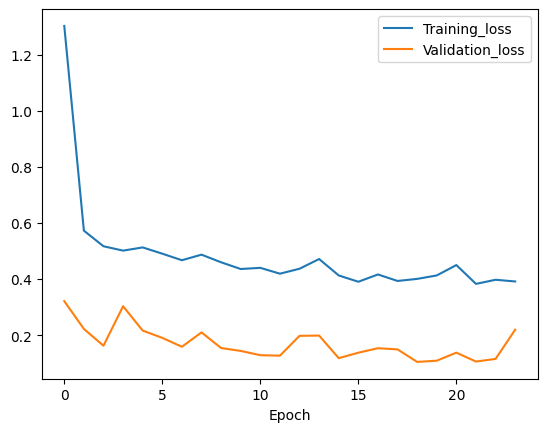

In [32]:
from sklearn.model_selection import train_test_split
## Stack three training sets
x = np.vstack(waveforms)
y = np.vstack(labels)
## data is shuffled before splitting
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.1,
                                                    shuffle = True,
                                                    random_state = 101)

## Train
hist = trainer(x_train, y_train,
        model_raw,
        epochs = 30,
        validation_split = 0.2,
        batch_size = 32,
        early_stop = True,
        verbose_training = 1,
        shuffle = True, # Shuffle the training data before each epoch
        plot_hist = True, save_plot = "Loss_curve.jpg"
       )

The training process took around 10 minutes. The output figure show the training and validation loss. The training loss is the objective function which is minimized during the training process.

## Testing the algorithm with real data

We use the `Picker.py` libary function for to evaluate the process.

In [33]:
!wget https://github.com/JiarunZhou/PKIKP_Onset_Picker/blob/main/Picker.py
from Picker import *

--2025-03-18 03:47:19--  https://github.com/JiarunZhou/PKIKP_Onset_Picker/blob/main/Picker.py
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Picker.py’

Picker.py               [ <=>                ] 388.55K  --.-KB/s    in 0.01s   

2025-03-18 03:47:19 (30.6 MB/s) - ‘Picker.py’ saved [397871]



SyntaxError: invalid character '·' (U+00B7) (Picker.py, line 107)

Here we load the trained model.

In [ ]:
!wget https://github.com/JiarunZhou/PKIKP_Onset_Picker/blob/main/TrainedModel.keras

--2025-03-12 05:59:31--  https://github.com/JiarunZhou/PKIKP_Onset_Picker/blob/main/TrainedModel.keras
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘TrainedModel.keras’

TrainedModel.keras      [ <=>                ] 221.41K  --.-KB/s    in 0.03s   

2025-03-12 05:59:31 (6.77 MB/s) - ‘TrainedModel.keras’ saved [226723]



In [ ]:
from tensorflow.keras.models import load_model

model = load_model('TrainedModel.keras')

ValueError: File not found: filepath=TrainedModel.keras. Please ensure the file is an accessible `.keras` zip file.

Read an observed real PKIKP waveform example. Here, the waveform has 150-s length. The predicted PKIKP onset by ak135 model (Kennett et al., 1995) is located at the 60th second. Hand-picked PKIKP absolute travel time is provided in its information.

In [ ]:
tr = read("Test_PKIKP/PKP_NE22.YP.BHZ.SAC")
PKIKP_travel_time = tr[0].stats.sac.t2
waveform_start = tr[0].stats.sac.b
onset = PKIKP_travel_time - waveform_start
prediction = 60

print("Wavefrom shape:",np.shape(tr))
print("PKIKP onset: ak135 prediction: %.2f s; Hand picking: %.2f s"%(prediction,onset))

Wavefrom shape: (1, 6001)
PKIKP onset: ak135 prediction: 60.00 s; Hand picking: 56.90 s


Pre-process the waveform. A default 50-s length waveform segment around the ak135 prediction is cut as the input of the automatic picker.

In [ ]:
sampling_rate = 40
len_input = 50
freq_filter = [0.5,2]
tr_cut = pre_process(tr, sampling_rate, len_input, freq_filter[0], freq_filter[1])

Pick the PKIKP onset on the processed waveform by calling the Picker function. A 20-s length window is shifting along the input waveform, and the network model returns an instantaneous pick for each step. The pick with the highest quality is chosen as the optimal one.

In [ ]:
auto_pick, quality = picker(tr_cut,model, sampling_rate, return_optimal = True)

print("Auto picked PKIKP onset: %.2f s picking quality: %.2f"%(auto_pick[0], quality[0]))
onset_in_window = onset - prediction + len_input / 2
print("Manual pick on the waveform: %.2f s"%onset_in_window)

Auto picked PKIKP onset: 21.66 s picking quality: 0.59
Manual pick on the waveform: 21.90 s


We can simply execute the Picker.py file to do the job above.

In [ ]:
!python Picker.py --data_list Test_PKIKP/List.txt --save_pick Test_PKIKP/Picks.txt --save_plot Test_PKIKP

Test_PKIKP/PKP_320.Z8.BHZ.SAC 
 Auto picked PKIKP onset: 24.66 s; Picking quality: 0.54
---------------
Test_PKIKP/PKP_DLV.RM.BHZ.SAC 
 Auto picked PKIKP onset: 26.79 s; Picking quality: 0.51
---------------
Test_PKIKP/PKP_NE22.YP.BHZ.SAC 
 Auto picked PKIKP onset: 21.66 s; Picking quality: 0.59
---------------


### Result plotting

We can acquire all picks with quality and get a quality plot.

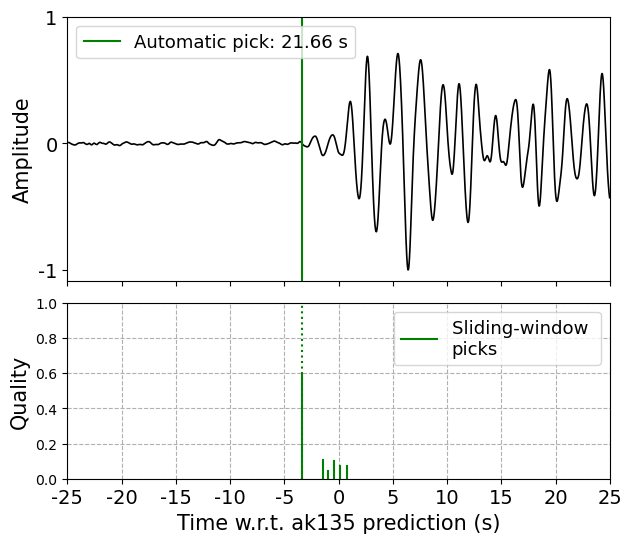

In [ ]:
auto_pick_plot(tr_cut, model, "Test_PKIKP/PKP_NE22.YP.BHZ.SAC.jpg")

An animation displaying the dynamic picking process is saved.

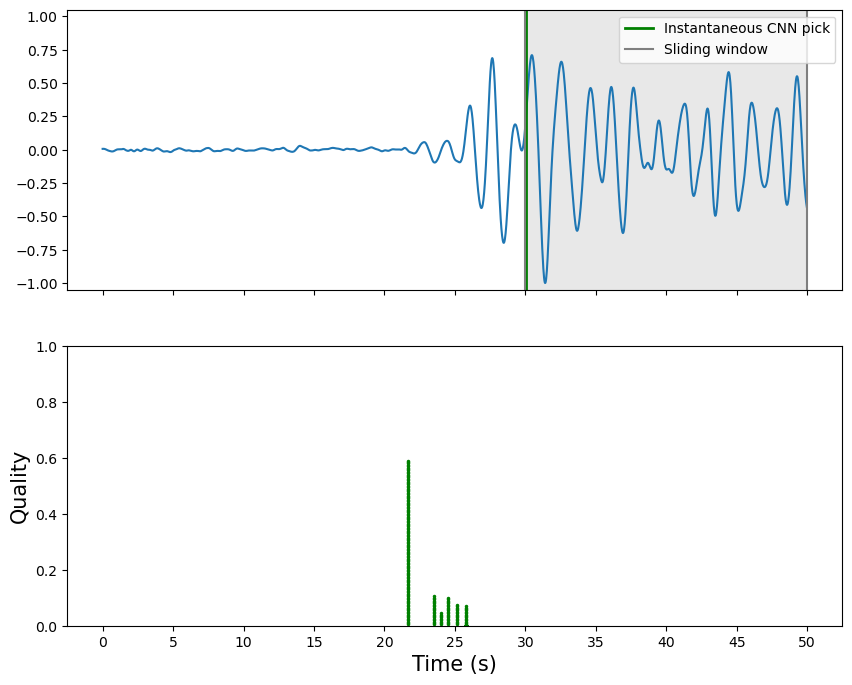

In [ ]:
picking_animation(tr_cut, model, save_name = "Test_PKIKP/Animation.mp4")